# Quickstart Example with Synthetic RTB Simulation (Customization)
This notebook provides an example of customizing the RTB environment.

This example on the Synthetic RTB Simulation consists of the following 4 steps:
1. Setup Synthetic RTB Simulation Environment and Interacting Online RL Agent
2. Standardized Environment
3. Customize Environmental Configuration
4. Customize Bidding Setup in RTB Env

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from ofrl.policy import OnlineHead

# import rtbgym modules
from rtbgym import RTBEnv, CustomizedRTBEnv
from rtbgym.utils import NormalDistribution

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state

In [5]:
from dataclasses import dataclass
from typing import Tuple, Union, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 1. Setup Synthetic RTB Simulation Environment and Interacting Online RL Agent
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the following.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

Let's see how it works!

In [8]:
# setup environment
env = RTBEnv(random_state=random_state)

In [9]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    )
)

In [10]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [11]:
# state consists of the following feedback from the environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


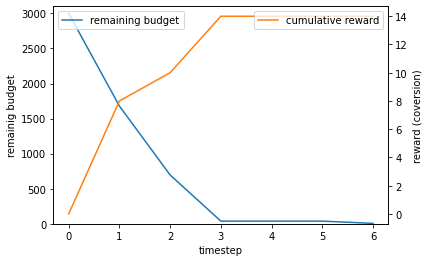

In [12]:
# let's visualize the transition of the remaining budget and cumulative reward
# our goal is to obtain a policy (or an agent) that maximizes the cumulative reward under budget constraints using RL.  
# for more visualization, please see the appendix.

def visualize_interaction_on_environment(env, agent):
    obs = env.reset()
    done = False
    remaining_budget = [obs[1]]
    cumulative_reward = [0]

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)
        remaining_budget.append(obs[1])
        cumulative_reward.append(cumulative_reward[-1] + reward)

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(remaining_budget[:-1], label='remaining budget')
    ax2 = ax1.twinx()
    ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
    ax1.set_xlabel('timestep')
    ax1.set_ylabel('remainig budget')
    ax1.set_ylim(0, env.initial_budget + 100)
    ax2.set_ylabel('reward (coversion)')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()
    
visualize_interaction_on_environment(env, agent)

## 1. Standardized Environment

We provide standardize RTB environment in both discrete and continuous action settings.  
These environment uses `sklearn.linear_model.LogisticRegression()` as s reward predictor and defines the following action space.

In [13]:
# discrete setting
env = gym.make("RTBEnv-discrete-v0")
print(env.action_meaning)

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


In [16]:
# discrete setting
env = gym.make("RTBEnv-continuous-v0")
print(env.action_space)

Box(0.1, 10.0, (1,), float64)


## 2. Customize Environmental Configuration
Now, we customize the RTB simulation environment.

We have the following environmental configurations:
- `objective`: Objective KPIs of RTB, which is either "click" or "conversion".
- `cost_indicator`: Timing of arising costs, which is any of "impression", "click", and "conversion".
- `step_per_episode`: Number of timesteps in an episode.
- `initial_budget`: Initial budget (i.e., constraint) for an episode.
- `n_ads`: Number of ads used for auction bidding.
- `n_users`: Number of users used for auction bidding.
- `ad_feature_dim`: Dimensions of the ad feature vectors.
- `user_feature_dim`: Dimensions of the user feature vectors.
- `ad_feature_vector`: Feature vectors that characterizes each ad.
- `user_feature_vector`: Feature vectors that characterizes each user.
- `ad_sampling_rate`: Sampling probabilities to determine which ad (id) is used in each auction.
- `user_sampling_rate`: Sampling probabilities to determine which user (id) is used in each auction.
- `WinningPriceDistribution`: Winning price distribution of auctions.
- `ClickTroughRate`: Click through rate (i.e., click / impression).
- `ConversionRate`: Conversion rate (i.e., conversion / click).
- `standard_bid_price_distribution`: Distribution of the bid price whose average impression probability is expected to be 0.5.
- `minimum_standard_bid_price`: Minimum value for standard bid price.
- `search_volume_distribution`: Search volume distribution for each timestep.
- `minimum_search_volume`: Minimum search volume at each timestep.
- `random_state`: Random state.

#### Case 1. Customizing the Basic Setup

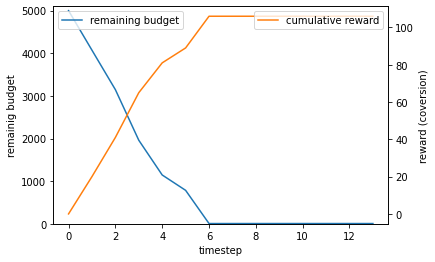

In [14]:
env = RTBEnv(
    objective="click",  # maximize the number of total impressions
    cost_indicator="click",  # cost arises every time click occurs
    step_per_episode=14,  # 14 days as an episode
    initial_budget=5000,  # budget available for 14 dayas is 5000
    random_state=random_state,
)
visualize_interaction_on_environment(env, agent)

#### Case 2. Defining the Ads and Users

In [15]:
# we use the following ads for bidding
ad_features = np.sign(random_.normal(size=(5, 10))).astype(int)
ad_names, feature_names = [f"ad{i+1}" for i in range(5)], [f"feature{i+1}" for i in range(10)]
ad_df = pd.DataFrame(ad_features, columns=feature_names, index=ad_names)
ad_df

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10
ad1,-1,1,-1,-1,1,1,1,1,1,1
ad2,1,-1,1,1,1,1,-1,-1,1,-1
ad3,-1,1,1,-1,-1,1,1,1,1,1
ad4,-1,-1,-1,-1,-1,1,-1,1,-1,1
ad5,-1,-1,-1,-1,-1,1,1,-1,1,1


In [16]:
# we assume that the following 100 users randomly cast search queries
user_features = random_.normal(size=(100, 5))
user_names, feature_names = [f"user{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
user_df = pd.DataFrame(user_features, columns=feature_names, index=user_names)
user_df

,feature1,feature2,feature3,feature4,feature5
user1,0.069877,0.246674,-0.011862,1.004812,1.327195
user2,-0.919262,-1.549106,0.022185,0.758363,-0.660524
user3,0.862580,-0.010032,0.050009,0.670216,0.852965
user4,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302
user5,-1.332610,1.074623,0.723642,0.690002,1.001543
...,...,...,...,...,...
user96,-1.686933,1.089539,2.060882,-0.241235,-0.947872
user97,0.676294,-0.653356,-0.652295,0.528828,0.357793
user98,0.188649,0.869417,-0.050667,-0.716365,-0.103259
user99,-1.141037,-0.500777,-0.389301,-0.473851,0.128664


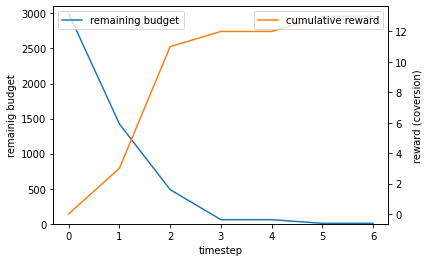

In [17]:
# using the above data, we can simulate an auction as follows
# note that, ad_sampling_rate and user_sampling_rate can be defined for each timestep or across timesteps
# by giving array with shape (timestep, n_ads/users) or (n_ads/users, )
env = RTBEnv(
    step_per_episode=7,  # 7 days in a week
    n_ads=5,  # we use 5 ads
    n_users=100,  # 100 users exists
    ad_feature_dim=10,  # each ad has 10-dimensional features
    user_feature_dim=5,  # each user has 5-dimensional features
    ad_feature_vector=ad_features,  # use ad features defined above
    user_feature_vector=user_features,  # use user features defined above
    ad_sampling_rate=np.ones(5) / 5,  # uniformly sample all ads in simulation
    user_sampling_rate=np.ones((7, 100)) / 100,  # uniformly sample all users in simulation *for every timestep*
    random_state=random_state,
)
visualize_interaction_on_environment(env, agent)

#### Case 3. Using Customized WinninPriceDistribution, ClickTroughRate, and ConversionRate

In [18]:
# Let's first define WinningPriceDistribution using bid price.
# note that, we use gamma distribution to simulate an auctionnning price distribution as default.
# please refer to rtbgym.WinningPriceDistribution as well.

from rtbgym import BaseWinningPriceDistribution

@dataclass
class CustomizedWinningPriceDistribution(BaseWinningPriceDistribution):
    """Initialization."""
    n_ads: int
    n_users: int
    ad_feature_dim: int
    user_feature_dim: int
    step_per_episode: int
    standard_bid_price_distribution: NormalDistribution = NormalDistribution(
        mean=50,
        std=5,
        random_state=12345,
    )
    minimum_standard_bid_price: Optional[Union[int, float]] = None
    random_state: Optional[int] = None
    
    def __post_init__(self):
        self.random_ = check_random_state(self.random_state)
    
    def sample_outcome(
        self,
        bid_prices: np.ndarray,
        **kwargs,
    ) -> Tuple[np.ndarray]:
        """Stochastically determine impression and second price for each auction."""
        # sample winning price from simple normal distribution
        winning_prices = self.random_.normal(
            loc=self.standard_bid_price,
            scale=self.standard_bid_price / 5,
            size=bid_prices.shape,
        )
        impressions = winning_prices < bid_prices
        return impressions.astype(int), winning_prices.astype(int)
    
    @property
    def standard_bid_price(self):
        return self.standard_bid_price_distribution.mean

In [19]:
# Here, we also customize ClickTroughRate and ConversionRate using both user and ad feature vectors.
# please refer to rtbgym.ClickThroughRate, rtbgym.ConversionRate as well.

from rtbgym import BaseClickAndConversionRate
from rtbgym.utils import sigmoid

@dataclass
class CustomizedClickThroughRate(BaseClickAndConversionRate):
    """Initialization."""
    n_ads: int
    n_users: int
    ad_feature_dim: int
    user_feature_dim: int
    step_per_episode: int
    random_state: Optional[int] = None
    
    def __post_init__(self):
        self.random_ = check_random_state(self.random_state)
        self.ad_coef = self.random_.normal(
            loc=0.0, 
            scale=0.5, 
            size=(self.ad_feature_dim, 10),
        )
        self.user_coef = self.random_.normal(
            loc=0.0, 
            scale=0.5, 
            size=(self.user_feature_dim, 10),
        )
    
    def calc_prob(
        self,
        ad_ids: np.ndarray,
        user_ids: np.ndarray,
        ad_feature_vector: np.ndarray,
        user_feature_vector: np.ndarray,
        timestep: Union[int, np.ndarray],
    ) -> np.ndarray:
        """Calculate CTR (i.e., click per impression)."""
        ad_latent = ad_feature_vector @ self.ad_coef
        user_latent = user_feature_vector @ self.user_coef
        ctrs = sigmoid((ad_latent * user_latent).mean(axis=1))
        return ctrs
    
    def sample_outcome(
        self,
        ad_ids: np.ndarray,
        user_ids: np.ndarray,
        ad_feature_vector: np.ndarray,
        user_feature_vector: np.ndarray,
        timestep: Union[int, np.ndarray],
    ) -> np.ndarray:
        """Stochastically determine whether click occurs in impression=True case."""
        ctrs = self.calc_prob(
            timestep=timestep,
            ad_ids=ad_ids,
            user_ids=user_ids,
            ad_feature_vector=ad_feature_vector,
            user_feature_vector=user_feature_vector,
        )
        clicks = self.random_.rand(len(ad_ids)) < ctrs
        return clicks.astype(int)

In [20]:
@dataclass
class CustomizedConversionRate(BaseClickAndConversionRate):
    """Initialization."""
    n_ads: int
    n_users: int
    ad_feature_dim: int
    user_feature_dim: int
    step_per_episode: int
    random_state: Optional[int] = None

    def __post_init__(self):
        self.random_ = check_random_state(self.random_state + 1)
        self.ad_coef = self.random_.normal(
            loc=0.0, 
            scale=0.5, 
            size=(self.ad_feature_dim, 10),
        )
        self.user_coef = self.random_.normal(
            loc=0.0, 
            scale=0.5, 
            size=(self.user_feature_dim, 10),
        )
    
    def calc_prob(
        self,
        ad_ids: np.ndarray,
        user_ids: np.ndarray,
        ad_feature_vector: np.ndarray,
        user_feature_vector: np.ndarray,
        timestep: Union[int, np.ndarray],
    ) -> np.ndarray:
        """Calculate CVR (i.e., conversion per click)."""
        ad_latent = ad_feature_vector @ self.ad_coef
        user_latent = user_feature_vector @ self.user_coef
        cvrs = sigmoid((ad_latent * user_latent).mean(axis=1))
        return cvrs
    
    def sample_outcome(
        self,
        ad_ids: np.ndarray,
        user_ids: np.ndarray,
        ad_feature_vector: np.ndarray,
        user_feature_vector: np.ndarray,
        timestep: Union[int, np.ndarray],
    ) -> np.ndarray:
        """Stochastically determine whether conversion occurs in click=True case."""
        cvrs = self.calc_prob(
            timestep=timestep,
            ad_ids=ad_ids,
            user_ids=user_ids,
            ad_feature_vector=ad_feature_vector,
            user_feature_vector=user_feature_vector,
        )
        conversions = self.random_.rand(len(ad_ids)) < cvrs
        return conversions.astype(int)

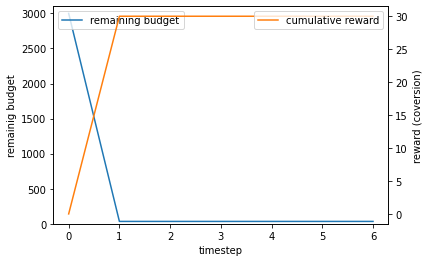

In [21]:
env = RTBEnv(
    WinningPriceDistribution=CustomizedWinningPriceDistribution,
    ClickThroughRate=CustomizedClickThroughRate,
    ConversionRate=CustomizedConversionRate,
    random_state=random_state,
)
visualize_interaction_on_environment(env, agent)

#### Case 4. Adjusting Standard Bid Price and Search Volume Distribution

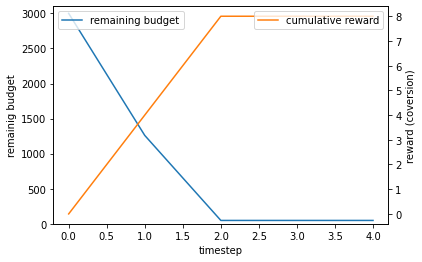

In [22]:
env = RTBEnv(
    step_per_episode=5,  # 5 days a week
    standard_bid_price_distribution=NormalDistribution(
        mean=100, 
        std=10, 
        random_state=random_state
    ),
    minimum_standard_bid_price=70,  # minimum standard bid price is 70
    search_volume_distribution=NormalDistribution(
        mean=np.array([100, 200, 100, 200, 300]),  # search volume varies day by day (depending on timestep)
        std=np.ones(5) * 20,
        random_state=random_state,
    ),
    minimum_search_volume=50,  # everyday, at least 50 queries are searched
    random_state=random_state,
)
visualize_interaction_on_environment(env, agent)

## 3. Customize Bidding Setup in RTB Env
Here, we describe how the decision makers can customize their own RTB environment.  
Specifically, they can setup their own action space and bid price calculation rules by defining the following modules.
- `reward_predictor` in Bidder class  
    We use predicted rewards to calculate the bid price.  
        bid price = adjust rate * predicted reward ( * constant)
    If None, we use the ground-truth reward instead of the predicted reward.  

- `scaler` in Bidder class
    Scaler defines constant in the bid price calculation.  
        bid price = adjust rate * predicted reward ( * constant)
        constant = scaler * standard_bid_price
    where standard_bid_price indicates the average of standard_bid_price  
    (bid price which has approximately 50% impression probability) over all ads.

- `action_space` for agent  
    We transform continual adjust rate space $[0, \infty)$ into agent action space $[0.1, 10]$.  
    Both discrete and continuous actions are acceptable.  
    (We can tune multiplication of adjust rate using scaler.)
    
The arguments are given as follows:
- `original_env`: Original RTB Environment.
- `reward_predictor`: A machine learning model to predict the reward to determine the bidding price.
- `scaler`: Scaling factor (constant value) used for bid price determination. (`None` for the auto-fitting)
- `action_min`: Minimum value of adjust rate.
- `action_max`: Maximum value of adjust rate.
- `action_type`: Action type of the RL agent, which should either be "discrete" or "continuous".
- `n_actions`: Number of "discrete" actions.
- `action_meaning`: Mapping function of agent action index to the actual "discrete" action to take.

In [23]:
# initialize environment
env = RTBEnv(random_state=random_state)

#### Case 1. Defining Continuous Action Space

In [24]:
# let's customize the continuous action space
custom_env = CustomizedRTBEnv(
    original_env=env,
    action_type="continuous",
)

In [25]:
print(custom_env.action_space)

Box(0.1, 10.0, (1,), float64)


In [26]:
# another example
custom_env = CustomizedRTBEnv(
    original_env=env,
    action_min=0.1,
    action_max=0.5,
    action_type="continuous",
)

In [27]:
print(custom_env.action_space)

Box(0.1, 0.5, (1,), float64)


#### Case 2. Defining Discrete Action Space

In [28]:
# let's customize the environment and discretize the action space
custom_env = CustomizedRTBEnv(
    original_env=env,
    action_type="discrete",
)

In [29]:
print(custom_env.action_space)
print(custom_env.action_meaning)

Discrete(10)
[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


In [30]:
# another example
custom_env = CustomizedRTBEnv(
    original_env=env,
    action_type="discrete",
    n_actions=5,
    action_meaning=np.arange(1, 6)
)

In [31]:
print(custom_env.action_space)
print(custom_env.action_meaning)

Discrete(5)
[1 2 3 4 5]


#### Case 3. Using Customized Reward Predictor

In [32]:
custom_env = CustomizedRTBEnv(
    original_env=env,
    reward_predictor=LogisticRegression(),  # use logistic regression as a reward predictor
    action_type="discrete",
)

In [33]:
custom_env = CustomizedRTBEnv(
    original_env=env,
    reward_predictor=None,  # use ground-truth (expected) reward as a reward predictor (oracle)
    action_type="discrete",
)

For data collection and visualization, please refer to [examples/quickstart/rtb_synthetic_data_collection.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_data_collection.ipynb). 

For offline RL and OPE, please refer to [examples/quickstart/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_basic.ipynb) and [examples/quickstart/rtb_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_basic.ipynb).

For advanced topics regarding OPE and OPS, please refer to [examples/quickstart/rtb_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_basic_advanced.ipynb) and [examples/quickstart/rtb_synthetic_continuous_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_advanced.ipynb).

## Reference

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.